# Phenotypic phase plane analysis
To analyse the cell factory's response to changes in conditions, most importantly oxygen and glucose, we perform a phenotypic phase plane analysis on the baseline growth and progesterone production.

In [108]:
from cobra.io import read_sbml_model
model = read_sbml_model('models/iMM904_progesterone.xml') # import model of progesterone producing yeast strain

growth = model.reactions.BIOMASS_SC5_notrace
progesterone = model.reactions.R02216

model

<Model iMM904_progesterone at 0x7fe2cfba2760>

Note that the medium contains a surplus of nutrients (denoted with 999999.0), but a restricted source of oxygen and D-glucose:

In [109]:
model.medium # nutrients available in medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

### Biomass vs. progesterone production

In [110]:
from cameo import phenotypic_phase_plane
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
plotter = PlotlyPlotter()
production_envelope = phenotypic_phase_plane(model,
                                             variables=[model.reactions.BIOMASS_SC5_notrace],
                                             objective=model.metabolites.progesterone_c, 
                                             points=10)
production_envelope.plot(plotter, height=400)

### Progesterone production and yield

In [112]:
# Generate production envelope for progesterone
from cobra.flux_analysis import production_envelope

N_POINTS = 100

with model:
    old_medium = model.medium
    new_medium = model.medium
    new_medium['EX_glc__D_e'] = 20.
    new_medium['EX_o2_e'] = 10.
    model.medium = new_medium
    #model.add_boundary(model.metabolites.get_by_id("progesterone_c"), type="demand")
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
    
    prod_env_prog = production_envelope(model, ["EX_o2_e", "EX_glc__D_e"], objective=progesterone, carbon_sources="EX_glc__D_e", points=N_POINTS)

progesterone_prod = prod_env_prog['flux_maximum']
progesterone_yield = prod_env_prog['carbon_yield_maximum']
o2_input = prod_env_prog['EX_o2_e']
glucose_input = prod_env_prog['EX_glc__D_e']

prod_env_prog

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  \
0      EX_glc__D_e           0.0                   0.0                 NaN   
1      EX_glc__D_e           0.0                   0.0                 NaN   
2      EX_glc__D_e           0.0                   0.0                 NaN   
3      EX_glc__D_e           0.0                   0.0                 NaN   
4      EX_glc__D_e           0.0                   0.0                 NaN   
...            ...           ...                   ...                 ...   
9995   EX_glc__D_e           0.0                   0.0                 NaN   
9996   EX_glc__D_e           0.0                   0.0                 NaN   
9997   EX_glc__D_e           NaN                   NaN                 NaN   
9998   EX_glc__D_e           NaN                   NaN                 NaN   
9999   EX_glc__D_e           NaN                   NaN                 NaN   

      flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_o2_e  \
0         0.762871              0.267005                 NaN    -10.0   
1         0.759100              0.268388                 NaN    -10.0   
2         0.755329              0.269800                 NaN    -10.0   
3         0.751558              0.271241                 NaN    -10.0   
4         0.747787              0.272712                 NaN    -10.0   
...            ...                   ...                 ...      ...   
9995      0.000000              0.000000                 NaN      0.0   
9996      0.000000              0.000000                 NaN      0.0   
9997           NaN                   NaN                 NaN      0.0   
9998           NaN                   NaN                 NaN      0.0   
9999           NaN                   NaN                 NaN      0.0   

      EX_glc__D_e  
0      -20.000000  
1      -19.798574  
2      -19.597148  
3      -19.395722  
4      -19.194296  
...           ...  
9995    -0.864528  
9996    -0.663102  
9997    -0.461676  
9998    -0.260250  
9999    -0.058824  

[10000 rows x 9 columns]

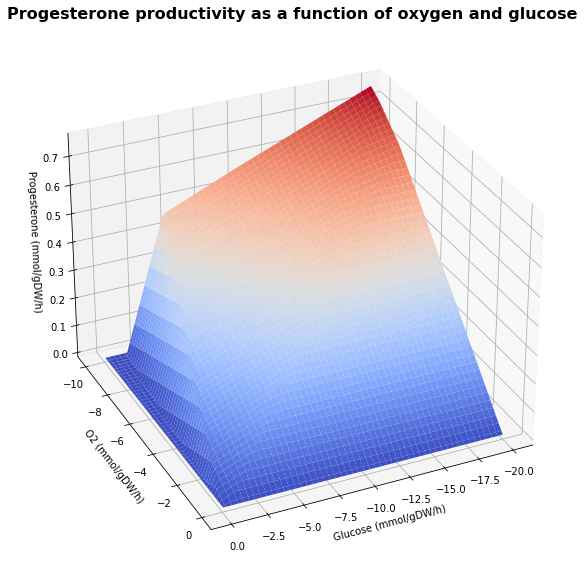

In [113]:
# Progesterone productivity as a function of oxygen and glucose
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(progesterone_prod).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Progesterone (mmol/gDW/h)")
ax.set_title("Progesterone productivity as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

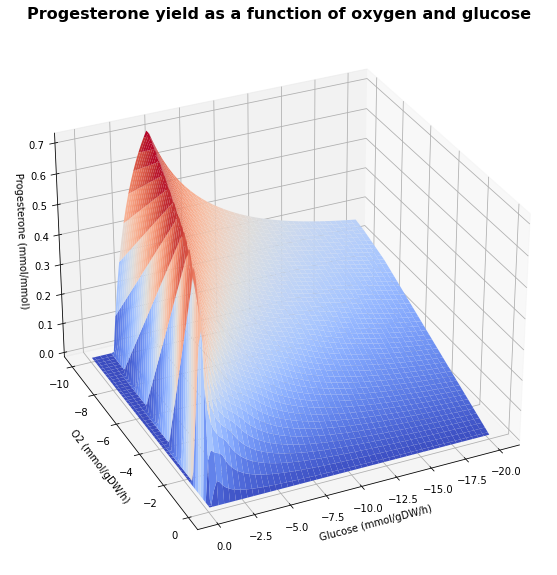

In [114]:
# Progesterone yield as a function of oxygen and glucose
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(progesterone_yield).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Progesterone (mmol/mmol)")
ax.set_title("Progesterone yield as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

In [115]:
# Generate production envelope
from cobra.flux_analysis import production_envelope

N_POINTS = 100

with model:
    new_medium = model.medium
    new_medium['EX_glc__D_e'] = 20.
    new_medium['EX_o2_e'] = 10.
    model.medium = new_medium
    prod_env_growth = production_envelope(model, ["EX_o2_e", "EX_glc__D_e"], objective=growth, carbon_sources="EX_glc__D_e", points=N_POINTS)

growth_prod = prod_env_growth['flux_maximum']
growth_yield = prod_env_growth['carbon_yield_maximum']
o2_input = prod_env_growth['EX_o2_e']
glucose_input = prod_env_growth['EX_glc__D_e']

prod_env_growth

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  \
0      EX_glc__D_e           0.0                   0.0                 NaN   
1      EX_glc__D_e           0.0                   0.0                 NaN   
2      EX_glc__D_e           0.0                   0.0                 NaN   
3      EX_glc__D_e           0.0                   0.0                 NaN   
4      EX_glc__D_e           0.0                   0.0                 NaN   
...            ...           ...                   ...                 ...   
9995   EX_glc__D_e           0.0                   0.0                 NaN   
9996   EX_glc__D_e           0.0                   0.0                 NaN   
9997   EX_glc__D_e           NaN                   NaN                 NaN   
9998   EX_glc__D_e           NaN                   NaN                 NaN   
9999   EX_glc__D_e           NaN                   NaN                 NaN   

      flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_o2_e  \
0         0.774109              4.055701                 NaN    -10.0   
1         0.769324              4.071636                 NaN    -10.0   
2         0.764538              4.087898                 NaN    -10.0   
3         0.759753              4.104498                 NaN    -10.0   
4         0.754968              4.121447                 NaN    -10.0   
...            ...                   ...                 ...      ...   
9995      0.000000              0.000000                 NaN      0.0   
9996      0.000000              0.000000                 NaN      0.0   
9997           NaN                   NaN                 NaN      0.0   
9998           NaN                   NaN                 NaN      0.0   
9999           NaN                   NaN                 NaN      0.0   

      EX_glc__D_e  
0      -20.000000  
1      -19.798574  
2      -19.597148  
3      -19.395722  
4      -19.194296  
...           ...  
9995    -0.864528  
9996    -0.663102  
9997    -0.461676  
9998    -0.260250  
9999    -0.058824  

[10000 rows x 9 columns]

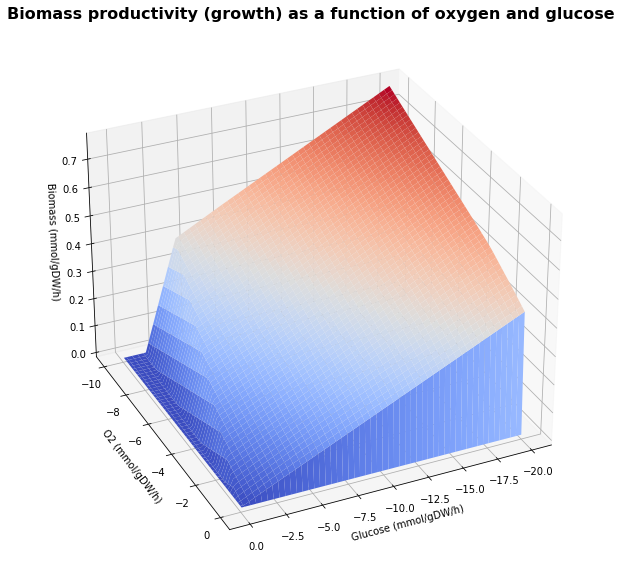

In [96]:
# Biomass productivity as a function of oxygen and glucose
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X, Y, np.nan_to_num(np.array(growth_prod).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Biomass (mmol/gDW/h)")
ax.set_title("Biomass productivity (growth) as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

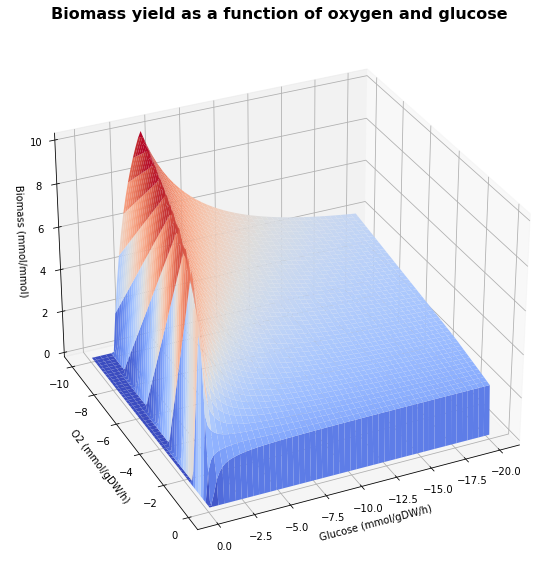

In [97]:
# Progesterone yield as a function of oxygen and glucose
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], o2_input[::N_POINTS])
ax.view_init(30,65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(growth_yield).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("O2 (mmol/gDW/h)")
ax.set_zlabel("Biomass (mmol/mmol)")
ax.set_title("Biomass yield as a function of oxygen and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

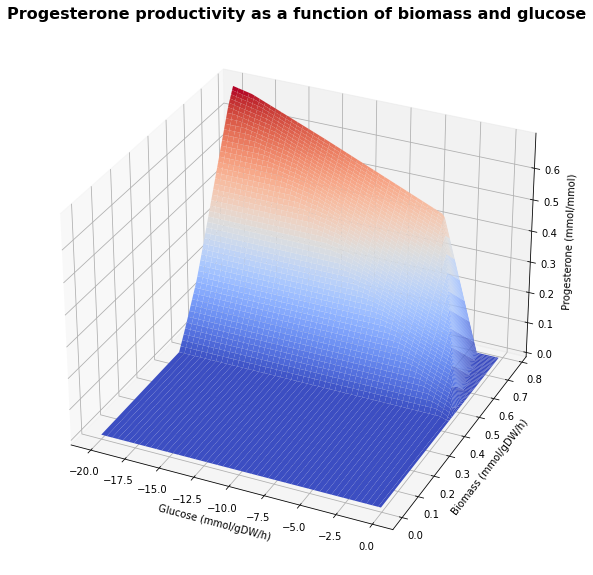

In [102]:
# Progesterone yield as a function of oxygen and glucose
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glucose_input[:N_POINTS], growth_prod[::N_POINTS])
ax.view_init(30,-65)
ax.plot_surface(X,Y, np.nan_to_num(np.array(progesterone_prod).reshape(N_POINTS, N_POINTS)), shade=True, cmap=cm.coolwarm)
#ax.invert_xaxis()
ax.set_xlabel("Glucose (mmol/gDW/h)")
ax.set_ylabel("Biomass (mmol/gDW/h)")
ax.set_zlabel("Progesterone (mmol/mmol)")
ax.set_title("Progesterone productivity as a function of biomass and glucose", {'fontsize': 16, 'fontweight': 'bold'})
plt.show()

In [ ]:
# Generate production envelope
from cobra.flux_analysis import production_envelope

N_POINTS = 100

with model:
    old_medium = model.medium
    new_medium = model.medium
    new_medium['EX_glc__D_e'] = 20.
    new_medium['EX_o2_e'] = 10.
    model.medium = new_medium
    prod_env_growth = production_envelope(model, ["EX_o2_e", "EX_glc__D_e"], objective=growth, carbon_sources="EX_glc__D_e", points=N_POINTS)

growth_prod = prod_env_growth['flux_maximum']
growth_yield = prod_env_growth['carbon_yield_maximum']
o2_input = prod_env_growth['EX_o2_e']
glucose_input = prod_env_growth['EX_glc__D_e']

prod_env_growth

In [ ]:
from cobra.flux_analysis import production_envelope
with model:
    old_medium = model.medium
    new_medium = model.medium
    new_medium['EX_glc__D_e'] = 100.
    new_medium['EX_o2_e'] = 100.
    model.medium = new_medium
    prod_env_prog = production_envelope(model, ["EX_o2_e", "EX_glc__D_e"], objective=growth, carbon_sources="EX_glc__D_e")

In [8]:
from cameo.strain_design.deterministic import DifferentialFVA

reference_model = model.copy()
biomass_rxn = reference_model.reactions.BIOMASS_SC5_notrace
biomass_rxn.lower_bound = 0.
target = reference_model.metabolites.progesterone_c
diffFVA = DifferentialFVA(design_space_model=model,
                          reference_model=reference_model,
                          objective=target,
                          variables=[biomass_rxn],
                          normalize_ranges_by=biomass_rxn,
                          points=10)

In [9]:
result = diffFVA.run(surface_only=True)

HBox()

In [ ]:
result.groups.groups.keys()

In [41]:
result.display_on_map(1, map_name="iMM904.Central carbon metabolism")

Builder(reaction_data={'6PGLter': 4.462386982707796, 'ATPM': 27.790736781292953, 'C14STR': 4.462386982513171, …

In [22]:
result.solutions

lower_bound  upper_bound  gaps  normalized_gaps   biomass  \
reaction                                                                   
13BGH                  0.0     5.190476   0.0              NaN  0.000000   
13BGHe                 0.0     0.000000   0.0              NaN  0.000000   
13GS                   0.0     5.190476   0.0              NaN  0.000000   
16GS                   0.0     0.000000   0.0              NaN  0.000000   
23CAPPD                0.0     0.000000   0.0              NaN  0.000000   
...                    ...          ...   ...              ...       ...   
YUMPS                  0.0     0.000000   0.0              0.0  0.255881   
ZYMSTAT_SC             0.0     0.000000   0.0              0.0  0.255881   
ZYMSTESTH_SC           0.0     0.000000   0.0              0.0  0.255881   
ZYMSTESTH_SCe          0.0     0.000000   0.0              0.0  0.255881   
ZYMSTt                 0.0     0.000000   0.0              0.0  0.255881   

               production     KO  flux_reversal  suddenly_essential  \
reaction                                                              
13BGH            0.142857  False          False               False   
13BGHe           0.142857   True          False               False   
13GS             0.142857  False          False               False   
16GS             0.142857   True          False               False   
23CAPPD          0.142857   True          False               False   
...                   ...    ...            ...                 ...   
YUMPS            0.033694   True          False               False   
ZYMSTAT_SC       0.033694   True          False               False   
ZYMSTESTH_SC     0.033694   True          False               False   
ZYMSTESTH_SCe    0.033694   True          False               False   
ZYMSTt           0.033694   True          False               False   

               free_flux       reaction  excluded  
reaction                                           
13BGH              False          13BGH     False  
13BGHe             False         13BGHe     False  
13GS               False           13GS     False  
16GS               False           16GS     False  
23CAPPD            False        23CAPPD     False  
...                  ...            ...       ...  
YUMPS              False          YUMPS     False  
ZYMSTAT_SC         False     ZYMSTAT_SC     False  
ZYMSTESTH_SC       False   ZYMSTESTH_SC     False  
ZYMSTESTH_SCe      False  ZYMSTESTH_SCe     False  
ZYMSTt             False         ZYMSTt     False  

[12798 rows x 12 columns]

In [51]:
prod_env_growth_simple = production_envelope(yeast_model, "EX_glc__D_e", objective=growth)
prod_env_growth_simple

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  \
0    EX_glc__D_e           0.0                   0.0                 NaN   
1    EX_glc__D_e           0.0                   0.0                 NaN   
2    EX_glc__D_e           0.0                   0.0                 NaN   
3    EX_glc__D_e           0.0                   0.0                 NaN   
4    EX_glc__D_e           0.0                   0.0                 NaN   
5    EX_glc__D_e           0.0                   0.0                 NaN   
6    EX_glc__D_e           0.0                   0.0                 NaN   
7    EX_glc__D_e           0.0                   0.0                 NaN   
8    EX_glc__D_e           0.0                   0.0                 NaN   
9    EX_glc__D_e           0.0                   0.0                 NaN   
10   EX_glc__D_e           0.0                   0.0                 NaN   
11   EX_glc__D_e           0.0                   0.0                 NaN   
12   EX_glc__D_e           0.0                   0.0                 NaN   
13   EX_glc__D_e           0.0                   0.0                 NaN   
14   EX_glc__D_e           0.0                   0.0                 NaN   
15   EX_glc__D_e           0.0                   0.0                 NaN   
16   EX_glc__D_e           0.0                   0.0                 NaN   
17   EX_glc__D_e           0.0                   0.0                 NaN   
18   EX_glc__D_e           0.0                   0.0                 NaN   
19   EX_glc__D_e           0.0                   0.0                 NaN   

    flux_maximum  carbon_yield_maximum  mass_yield_maximum   EX_glc__D_e  
0     548.398024          5.746316e+00                 NaN -10000.000000  
1     535.893977          5.927253e+00                 NaN  -9473.687307  
2     523.389930          6.129476e+00                 NaN  -8947.374613  
3     510.885882          6.356977e+00                 NaN  -8421.061920  
4     498.381835          6.614812e+00                 NaN  -7894.749226  
5     485.877787          6.909479e+00                 NaN  -7368.436533  
6     473.325828          7.248746e+00                 NaN  -6842.123839  
7     460.557953          7.640975e+00                 NaN  -6315.811146  
8     447.674961          8.102433e+00                 NaN  -5789.498452  
9     434.791969          8.656183e+00                 NaN  -5263.185759  
10    421.908978          9.332986e+00                 NaN  -4736.873065  
11    409.025986          1.017899e+01                 NaN  -4210.560372  
12    361.289962          1.027545e+01                 NaN  -3684.247678  
13    309.677110          1.027542e+01                 NaN  -3157.934985  
14    258.064258          1.027538e+01                 NaN  -2631.622291  
15    206.451407          1.027532e+01                 NaN  -2105.309598  
16    154.838555          1.027523e+01                 NaN  -1578.996904  
17    103.225703          1.027504e+01                 NaN  -1052.684211  
18     51.612852          1.027446e+01                 NaN   -526.371517  
19      0.000000          8.961658e-11                 NaN     -0.058824

<AxesSubplot: xlabel='Glucose uptake [mmol/g DW/h]', ylabel='Biomass objective [1/h]'>

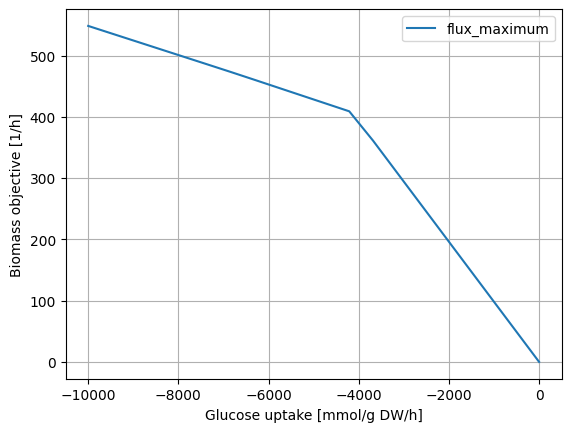

In [52]:
prod_env_growth_simple.plot(x='EX_glc__D_e', y='flux_maximum', xlabel="Glucose uptake [mmol/g DW/h]", ylabel="Biomass objective [1/h]", grid = True)

In [11]:
prod_env_progesterone_simple = production_envelope(yeast_model, "EX_glc__D_e", objective=progesterone)
prod_env_progesterone_simple

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  \
0    EX_glc__D_e           0.0                   0.0                 NaN   
1    EX_glc__D_e           0.0                   0.0                 NaN   
2    EX_glc__D_e           0.0                   0.0                 NaN   
3    EX_glc__D_e           0.0                   0.0                 NaN   
4    EX_glc__D_e           0.0                   0.0                 NaN   
5    EX_glc__D_e           0.0                   0.0                 NaN   
6    EX_glc__D_e           0.0                   0.0                 NaN   
7    EX_glc__D_e           0.0                   0.0                 NaN   
8    EX_glc__D_e           0.0                   0.0                 NaN   
9    EX_glc__D_e           0.0                   0.0                 NaN   
10   EX_glc__D_e           0.0                   0.0                 NaN   
11   EX_glc__D_e           0.0                   0.0                 NaN   
12   EX_glc__D_e           0.0                   0.0                 NaN   
13   EX_glc__D_e           0.0                   0.0                 NaN   
14   EX_glc__D_e           0.0                   0.0                 NaN   
15   EX_glc__D_e           0.0                   0.0                 NaN   
16   EX_glc__D_e           0.0                   0.0                 NaN   
17   EX_glc__D_e           0.0                   0.0                 NaN   
18   EX_glc__D_e           0.0                   0.0                 NaN   
19   EX_glc__D_e           0.0                   0.0                 NaN   

    flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_glc__D_e  
0            0.0                   0.0                 NaN -1000.000000  
1            0.0                   0.0                 NaN  -947.371517  
2            0.0                   0.0                 NaN  -894.743034  
3            0.0                   0.0                 NaN  -842.114551  
4            0.0                   0.0                 NaN  -789.486068  
5            0.0                   0.0                 NaN  -736.857585  
6            0.0                   0.0                 NaN  -684.229102  
7            0.0                   0.0                 NaN  -631.600619  
8            0.0                   0.0                 NaN  -578.972136  
9            0.0                   0.0                 NaN  -526.343653  
10           0.0                   0.0                 NaN  -473.715170  
11           0.0                   0.0                 NaN  -421.086687  
12           0.0                   0.0                 NaN  -368.458204  
13           0.0                   0.0                 NaN  -315.829721  
14           0.0                   0.0                 NaN  -263.201238  
15           0.0                   0.0                 NaN  -210.572755  
16           0.0                   0.0                 NaN  -157.944272  
17           0.0                   0.0                 NaN  -105.315789  
18           0.0                   0.0                 NaN   -52.687307  
19           0.0                   0.0                 NaN    -0.058824

<AxesSubplot: xlabel='Glucose uptake [mmol/g DW/h]', ylabel='Progesterrone'>

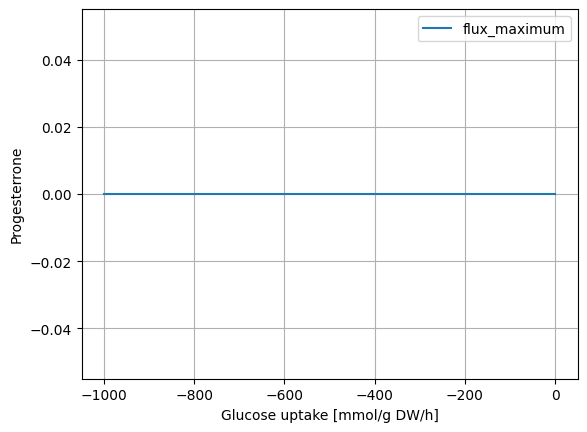

In [12]:
prod_env_progesterone_simple.plot(x='EX_glc__D_e', y='flux_maximum', xlabel="Glucose uptake [mmol/g DW/h]", ylabel="Progesterrone", grid = True)

In [33]:
prod_env_2 = production_envelope(yeast_model, reactions=["EX_glc__D_e"], carbon_sources="EX_glc__D_e")
prod_env_2.head()

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  \
0   EX_glc__D_e           0.0                   0.0                 NaN   
1   EX_glc__D_e           0.0                   0.0                 NaN   
2   EX_glc__D_e           0.0                   0.0                 NaN   
3   EX_glc__D_e           0.0                   0.0                 NaN   
4   EX_glc__D_e           0.0                   0.0                 NaN   

   flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_glc__D_e  
0     54.829111              5.745196                 NaN -1000.000000  
1     53.578773              5.926060                 NaN  -947.371517  
2     52.328434              6.128201                 NaN  -894.743034  
3     51.078096              6.355609                 NaN  -842.114551  
4     49.827757              6.613334                 NaN  -789.486068

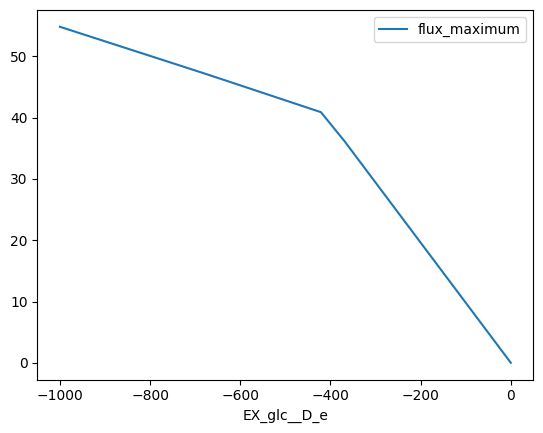

In [35]:
prod_env_2.plot(
    kind='line', x='EX_glc__D_e', y='flux_maximum');

In [ ]:
#data = phenotype_phase_plane.production_envelope(yeast_model, "EX_glc__D_e")
#print(data)
#data.plot_matplotlib();

#phenotypic_phase_plane(model, variables=[model.reactions.EX_glc__D_e], objective=model.metabolites.rHb_c) 

<AxesSubplot: xlabel='Glucose uptake [mmol/g DW/h]', ylabel='Biomass objective [1/h]'>

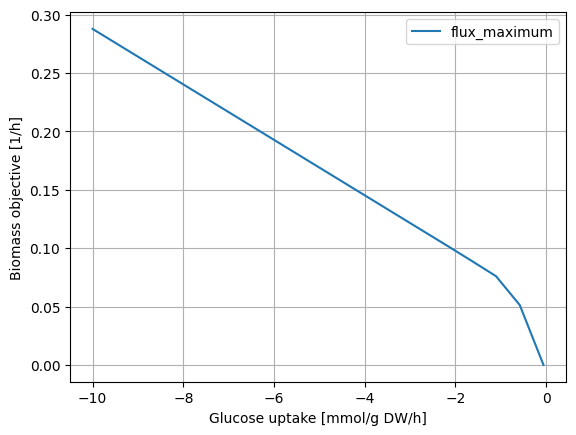

In [5]:
data.plot(x='EX_glc__D_e', y='flux_maximum', xlabel="Glucose uptake [mmol/g DW/h]", ylabel="Biomass objective [1/h]", grid = True)